In [ ]:
#!pip install xgboost shap

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, PrecisionRecallDisplay, average_precision_score, RocCurveDisplay


pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel('take_home_challenge_sample 2.xlsx')
display(df.head())

,account_id,current_session_start_at,game_id,game_type,account_game_session_playing_time,turnover_decile,account_game_session_spins_count,account_game_session_positive_ux_spins_count,account_game_session_first_launch,account_game_session_last_launch,churn_yn
0,BS/3x7csosler8oz6kZaJHckQ33CMdVportnuOgMQZw=,2025-06-29 19:34:40.636 UTC,ge9fsUna0OadTBI0QnsZ2Iz2hoJG/ytMq7/Oun9bx7Y=,IyFmfvIV+9zVi+Cg4Jf99ayIq5tFwz0PnbjqCAqzLFo=,6821,10,94,35,2025-06-29 19:34:40.636 UTC,2025-06-29 19:34:40.636 UTC,0
1,Qf775AXUZp7oztilLm/XeVOQpN6+dYlciFZgImdudPg=,2025-06-17 04:42:19.001 UTC,bQa0mipsHUszWBaM2q+RW84iQIP17HQUpJIimmktDL0=,9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,772,9,256,28,2025-06-17 04:42:19.001 UTC,2025-06-17 04:42:19.001 UTC,0
2,SlpwIRAd+uUw7OrGL5dvo7RX35eWCFUwRwjgYaNAUBY=,2025-05-15 09:58:40.067 UTC,tFzD9ba2Zlg+lAtsf5xOxx6kYhwk9UF6PJBJazP2+N8=,O0eKCj/GVd+d8FJyiBKFG2si3fSdqhEw/zfq/tBXQU8=,150,7,46,6,2025-05-15 09:58:40.067 UTC,2025-05-15 09:58:40.067 UTC,0
3,Wvf5SWCcTuvqi8yWfo94gOjXvrXYPat2+l+C9sTDS8o=,2025-05-05 01:44:01.659 UTC,4XUhrMZ9kOBxI2WS8pSH77lAnWvdrjxxMcybihXZobM=,O0eKCj/GVd+d8FJyiBKFG2si3fSdqhEw/zfq/tBXQU8=,721,8,51,5,2025-05-05 01:44:01.659 UTC,2025-05-05 01:55:02.016 UTC,0
4,oesprVCGSLDNdDIzCXq0s1NSKM56to+oWRg9xk4I1bU=,2025-05-03 06:37:17.049 UTC,t4SYyiDqOVRjrgNrMYnzHb32v/xsk581jzjcINP75Ug=,9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,304,9,95,9,2025-05-03 07:03:38.389 UTC,2025-05-03 07:03:38.389 UTC,0


# EDA

In [3]:
df.shape

(73004, 11)

In [4]:
df.duplicated().sum().sum() # remove duplicated values

np.int64(1519)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.duplicated().sum().sum()

np.int64(0)

In [7]:
df.churn_yn.value_counts(normalize=True) #unbalanced problem

,proportion
churn_yn,
1,0.760034
0,0.239966


In [8]:
churn_by_game_type = df.groupby(['game_type', 'churn_yn']).size().unstack(fill_value=0)
churn_by_game_type['Total'] = churn_by_game_type[0] + churn_by_game_type[1]
churn_by_game_type['% Churn 0'] = (churn_by_game_type[0] / churn_by_game_type['Total']) * 100
churn_by_game_type['% Churn 1'] = (churn_by_game_type[1] / churn_by_game_type['Total']) * 100
display(churn_by_game_type[['% Churn 0', '% Churn 1']])

#every game time is similar to the other with respect to churn

churn_yn,% Churn 0,% Churn 1
game_type,,
7syVeWUUf3aag6JXf5Wf7lzhjb9MlCClv4kzwafVNL8=,21.568627,78.431373
9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,23.708565,76.291435
IyFmfvIV+9zVi+Cg4Jf99ayIq5tFwz0PnbjqCAqzLFo=,25.666492,74.333508
O0eKCj/GVd+d8FJyiBKFG2si3fSdqhEw/zfq/tBXQU8=,23.854196,76.145804
YY3Fg3ndo0jroBBZesz3KpirTNNXtCrN2kCRkBsv8UQ=,20.788530,79.211470


In [9]:
df.dtypes # -> need to transform date features, for categoricals and numericals it depends on model- see below

,0
account_id,object
current_session_start_at,object
game_id,object
game_type,object
account_game_session_playing_time,int64
turnover_decile,int64
account_game_session_spins_count,int64
account_game_session_positive_ux_spins_count,int64
account_game_session_first_launch,object
account_game_session_last_launch,object


**Observation**

Checking the number of duplicated by account id is useful to understand how to formulate the problem: since we have 13625 duplicates but each of them has just one value of churn and current_session_start_at, it means that we have clients that in the First Session tried different types of games. Since our prediction will be per account_id, I will proceed in aggregating features per client in order to train the model, so I will have one record per client in the training set. At inference time I suppose we will wait for the first session to stop to collect all data needed by the model to predict churn in 30 days time.

In [10]:
df.account_id.duplicated().sum()

np.int64(13625)

In [15]:
# check one churn and current_session_start_at per account_id
session_counts = df.groupby('account_id')['current_session_start_at'].nunique()
multiple_sessions = session_counts[session_counts > 1]
assert(len(multiple_sessions)==0)
churn_counts = df.groupby('account_id')['churn_yn'].nunique()
multiple_churn = churn_counts[churn_counts > 1]
assert(len(multiple_churn)==0)

In [12]:
#checking one of the cases of users with multiple games played in same first session
df.groupby('account_id').size().reset_index(name='count').sort_values(by='count', ascending=False).head()

,account_id,count
46467,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,23
28598,TV1g1mF5wSoJiYCuSbwsu1Qa43xfvAraRpdaddoH0G8=,22
50084,rGKkfJV+uYeVRFF732WqnoH+ZabHIF7fWUgBZ+Kqnl8=,22
16926,GghSd9LTkWaDJbM86YMMHFSeFSq5yy57dkmHMW2Sv/4=,21
52896,uUCfhRwCgv3anHfYMy7Qn3btZLDnZGWDcyKxt9gp5IE=,20


In [13]:
df.loc[df['account_id']=='nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g='].sort_values(by=['account_game_session_first_launch','game_type','game_id']).head()

,account_id,current_session_start_at,game_id,game_type,account_game_session_playing_time,turnover_decile,account_game_session_spins_count,account_game_session_positive_ux_spins_count,account_game_session_first_launch,account_game_session_last_launch,churn_yn
5691,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,2025-06-13 20:18:20.766 UTC,YrKwYKdKZyKwOdSaCCNtffplTBa0GSG9YL1JgkTqVCk=,9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,1319,9,258,26,2025-06-13 20:18:20.766 UTC,2025-06-14 00:01:38.534 UTC,0
54876,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,2025-06-13 20:18:20.766 UTC,Ry83mPe0pTxZovtNqWlizP5djCYUfRAOFkjqHRWvK0k=,9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,71,5,15,1,2025-06-13 20:21:48.321 UTC,2025-06-14 00:34:10.243 UTC,0
4233,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,2025-06-13 20:18:20.766 UTC,hyJhYgQhft2znn35aeBpiu2OWZumLtLeHOSbA63g/t4=,9G9tOJktlWitEJQcpnnBU8rArMW4moSik8w66fPAMr4=,143,7,44,4,2025-06-13 20:23:43.598 UTC,2025-06-13 23:15:56.122 UTC,0
4677,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,2025-06-13 20:18:20.766 UTC,lwq/LbFo55Fc4BYk+n0sKCmFQHva3ny+1P79I4dFvfk=,O0eKCj/GVd+d8FJyiBKFG2si3fSdqhEw/zfq/tBXQU8=,211,7,86,10,2025-06-13 20:27:50.932 UTC,2025-06-14 00:41:41.886 UTC,0
2265,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,2025-06-13 20:18:20.766 UTC,vEBk1XzvUCdT/op/HXGQtMJGAtPnB6L2wHGXwSd+VpM=,O0eKCj/GVd+d8FJyiBKFG2si3fSdqhEw/zfq/tBXQU8=,110,6,42,4,2025-06-13 20:31:23.549 UTC,2025-06-14 00:42:51.825 UTC,0


# Feature engineering

After having a look at data, possible engineered features are:

* Engagement diversity: games_type_count number of games_id_count in session
* Average values/min/max values = for numerical features like account_game_session or turnover decile
* Win rate: avg(positive_spins_total / spins_total)
* Session intensity: spins_total / session_duration


In [16]:
df.isnull().sum() # no null values to handle

,0
account_id,0
current_session_start_at,0
game_id,0
game_type,0
account_game_session_playing_time,0
turnover_decile,0
account_game_session_spins_count,0
account_game_session_positive_ux_spins_count,0
account_game_session_first_launch,0
account_game_session_last_launch,0


Handling datetime features

In [20]:
date_cols = ["current_session_start_at", "account_game_session_first_launch", "account_game_session_last_launch"]
for col in date_cols:
  df[col] = pd.to_datetime(df[col], utc=True, format='mixed')


# Feature from time
df["session_dayofweek"] = df["current_session_start_at"].dt.dayofweek
df["session_hour"] = df["current_session_start_at"].dt.hour
df["session_month"] = df["current_session_start_at"].dt.month
df["is_weekend"] = df["current_session_start_at"].dt.dayofweek.isin([5,6]).astype(int)

# latency first launch current session = how much time to play after session starts
df["latency_first_launch_current_session"] = (df["account_game_session_first_launch"] - df["current_session_start_at"]).dt.total_seconds()
# delta last session current session = how much gaming session has last
df["delta_last_session_current_session"] = (df["account_game_session_last_launch"] - df["current_session_start_at"]).dt.total_seconds()




Processing data to aggregate values per account_id

In [22]:

def create_final_training_set(df):


    agg_df = df.groupby('account_id').agg(
        # Engagement
        games_count=('game_id', 'nunique'),
        game_types_count=('game_type', 'nunique'),

        # Play time
        avg_play_time=('account_game_session_playing_time', 'mean'),
        min_play_time=('account_game_session_playing_time', 'min'),
        max_play_time=('account_game_session_playing_time', 'max'),

        # Turnover
        avg_turnover_decile=('turnover_decile', 'mean'),
        min_turnover_decile=('turnover_decile', 'min'),
        max_turnover_decile=('turnover_decile', 'max'),

        # Spins
        total_spins=('account_game_session_spins_count', 'sum'),
        min_spins=('account_game_session_spins_count', 'min'),
        max_spins=('account_game_session_spins_count', 'max'),
        avg_spins=('account_game_session_spins_count', 'mean'),
        total_positive_spins=('account_game_session_positive_ux_spins_count', 'sum'),
        min_positive_spins=('account_game_session_positive_ux_spins_count', 'min'),
        max_positive_spins=('account_game_session_positive_ux_spins_count', 'max'),
        avg_positive_spins=('account_game_session_positive_ux_spins_count', 'mean'),

        # Feature temporali
        avg_latency_first_launch=('latency_first_launch_current_session', 'mean'),
        min_latency_first_launch=('latency_first_launch_current_session', 'min'),
        max_latency_first_launch=('latency_first_launch_current_session', 'max'),


        avg_delta_last_session=('delta_last_session_current_session', 'mean'),
        min_delta_last_session=('delta_last_session_current_session', 'min'),
        max_delta_last_session=('delta_last_session_current_session', 'max'),


        avg_session_dayofweek=('session_dayofweek', 'mean'),
        avg_session_hour=('session_hour', 'mean'),
        avg_session_month=('session_month', 'mean'),
        pct_weekend=('is_weekend', 'mean'),

        # Target
        churn_yn=('churn_yn', 'max')
    ).reset_index()

    # derived features
    agg_df['engagement_diversity'] = agg_df['game_types_count'] / agg_df['game_types_count'].max()
    agg_df['win_rate'] = agg_df['total_positive_spins'] / agg_df['total_spins'].replace(0, np.nan)
    agg_df['session_intensity'] = agg_df['total_spins'] / (agg_df['avg_play_time'] + 1e-6)

    #sorting values to compute trends
    df_sorted = df.sort_values(['account_id', 'account_game_session_first_launch'])

    # Delta first last sessione
    first_last = df_sorted.groupby('account_id').agg(
        first_session=('account_game_session_first_launch', 'min'),
        last_session=('account_game_session_first_launch', 'max'),
        total_sessions=('account_game_session_first_launch', 'count')
    ).reset_index()
    first_last['total_delta_sec_activity'] = (first_last['last_session'] - first_last['first_session']).dt.total_seconds()

    # Gap between sessions
    df_sorted['prev_session'] = df_sorted.groupby('account_id')['account_game_session_first_launch'].shift(1)
    df_sorted['session_gap_sec'] = (df_sorted['account_game_session_first_launch'] - df_sorted['prev_session']).dt.total_seconds()
    avg_session_gap = df_sorted.groupby('account_id')['session_gap_sec'].mean().reset_index().fillna(0)


    # Merge temporal
    temporal_df = first_last.merge(avg_session_gap, on='account_id', how='left')



    training_df_final = agg_df.merge(temporal_df, on='account_id', how='left')

    #Remove cols already used for new features
    training_df_final.drop(columns=['total_spins', 'total_positive_spins', 'first_session','last_session'], inplace=True)

    return training_df_final

# Uso della funzione
final_training_df = create_final_training_set(df)

final_training_df.head()


,account_id,games_count,game_types_count,avg_play_time,min_play_time,max_play_time,avg_turnover_decile,min_turnover_decile,max_turnover_decile,min_spins,max_spins,avg_spins,min_positive_spins,max_positive_spins,avg_positive_spins,avg_latency_first_launch,min_latency_first_launch,max_latency_first_launch,avg_delta_last_session,min_delta_last_session,max_delta_last_session,avg_session_dayofweek,avg_session_hour,avg_session_month,pct_weekend,churn_yn,engagement_diversity,win_rate,session_intensity,total_sessions,total_delta_sec_activity,session_gap_sec
0,+++nMptjB6kLaRmMzEyAWTaAGMNkW8tCmT5fi354Vss=,1,1,61.0,61,61,5.0,5,5,20,20,20.0,2,2,2.0,92.960,92.960,92.960,92.960,92.960,92.960,5.0,4.0,5.0,1.0,1,0.25,0.100000,0.327869,1,0.0,0.0
1,++//0gFGd5rtJOUkvq5Qt8qmXV/hRDt2VhpVMZkxOx4=,1,1,9.0,9,9,1.0,1,1,2,2,2.0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,3.0,6.0,6.0,0.0,1,0.25,0.000000,0.222222,1,0.0,0.0
2,++0IU521laVuxCDLQFeXs3B/Tm2Kcn+SKWg7Apo9E0w=,1,1,3231.0,3231,3231,10.0,10,10,51,51,51.0,13,13,13.0,0.000,0.000,0.000,0.000,0.000,0.000,5.0,20.0,5.0,1.0,1,0.25,0.254902,0.015785,1,0.0,0.0
3,++EH0tW4RTuoiV5Z7by4ibNnlnRGBtWY1l7PnVs9FNE=,1,1,263.0,263,263,3.0,3,3,13,13,13.0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,1.0,5.0,0.0,1,0.25,0.000000,0.049430,1,0.0,0.0
4,++HCHPC8It6PWo7kotLGvB7GOVNuXnfbHYk7PuyKaWM=,1,1,73.0,73,73,5.0,5,5,14,14,14.0,1,1,1.0,61.147,61.147,61.147,61.147,61.147,61.147,0.0,20.0,6.0,0.0,1,0.25,0.071429,0.191781,1,0.0,0.0


In [23]:


final_training_df.loc[final_training_df['account_id']=='nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=']

,account_id,games_count,game_types_count,avg_play_time,min_play_time,max_play_time,avg_turnover_decile,min_turnover_decile,max_turnover_decile,min_spins,max_spins,avg_spins,min_positive_spins,max_positive_spins,avg_positive_spins,avg_latency_first_launch,min_latency_first_launch,max_latency_first_launch,avg_delta_last_session,min_delta_last_session,max_delta_last_session,avg_session_dayofweek,avg_session_hour,avg_session_month,pct_weekend,churn_yn,engagement_diversity,win_rate,session_intensity,total_sessions,total_delta_sec_activity,session_gap_sec
46467,nEbr7cxQGyr3jPw8RgK3qUV+Ea8e+D77SZ4tN+VaB0g=,23,2,232.304348,16,1568,5.130435,1,9,4,258,45.956522,0,32,5.0,6589.911435,0.0,15634.199,11449.111565,2393.617,15871.059,4.0,20.0,6.0,0.0,0,0.5,0.108798,4.550065,23,15634.199,710.645409


In [45]:
final_training_df.churn_yn.value_counts(normalize=True) #unbalanced problem - new target %

,proportion
churn_yn,
1,0.808382
0,0.191618


# Eda

In [24]:
final_training_df.describe()

,games_count,game_types_count,avg_play_time,min_play_time,max_play_time,avg_turnover_decile,min_turnover_decile,max_turnover_decile,min_spins,max_spins,avg_spins,min_positive_spins,max_positive_spins,avg_positive_spins,avg_latency_first_launch,min_latency_first_launch,max_latency_first_launch,avg_delta_last_session,min_delta_last_session,max_delta_last_session,avg_session_dayofweek,avg_session_hour,avg_session_month,pct_weekend,churn_yn,engagement_diversity,win_rate,session_intensity,total_sessions,total_delta_sec_activity,session_gap_sec
count,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,5.786000e+04,57860.000000,57860.000000,57860.000000
mean,1.235465,1.069305,276.100054,234.646854,330.223937,5.113537,4.916436,5.295437,34.234359,48.963515,40.553511,3.952195,5.848168,4.764693,373.217615,240.379526,510.275462,497.053825,363.774277,620.618355,3.150000,12.719409,5.483063,0.314328,0.808382,0.267326,0.106898,5.250632e+04,1.235482,269.895936,157.451870
std,0.770330,0.263526,724.908498,682.175734,890.842533,2.701504,2.716461,2.818479,100.337531,150.466253,113.320712,12.223841,17.004290,13.198473,1061.804768,787.151276,1571.055533,1440.535331,1132.353277,1849.950682,2.007561,7.377505,0.499994,0.464252,0.393577,0.065882,0.138586,2.400650e+05,0.770583,1265.262967,632.519543
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.250000,0.000000,1.149425e-03,1.000000,0.000000,0.000000
25%,1.000000,1.000000,32.000000,27.000000,33.000000,3.000000,3.000000,3.000000,5.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,5.000000,0.000000,1.000000,0.250000,0.000000,1.520468e-01,1.000000,0.000000,0.000000
50%,1.000000,1.000000,76.000000,63.000000,79.000000,5.000000,5.000000,5.000000,12.000000,14.000000,14.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,14.000000,5.000000,0.000000,1.000000,0.250000,0.083333,2.400758e-01,1.000000,0.000000,0.000000
75%,1.000000,1.000000,231.000000,176.000000,262.000000,7.000000,7.000000,8.000000,27.000000,38.000000,34.000000,3.000000,5.000000,4.000000,231.335125,79.820000,273.473000,306.648750,172.172500,357.739750,5.000000,19.000000,6.000000,1.000000,1.000000,0.250000,0.142857,3.750000e-01,1.000000,0.000000,0.000000
max,23.000000,4.000000,29448.000000,29448.000000,29448.000000,10.000000,10.000000,10.000000,6977.000000,14233.000000,8298.500000,693.000000,693.000000,693.000000,40049.348167,27475.543000,50218.717000,40049.348167,36700.958000,55029.113000,6.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,5.000000e+06,23.000000,50218.717000,29341.061000


## Correlations with the Target
All correlations are negative (-0.18 to -0.30), which means that The higher the feature, the less likely churn becomes -> More active/engaged users tend to stay

1. `max_turnover_decile` (-0.30): Big spenders are more likely to stay
2. `avg_turnover_decile` (-0.28): Consistent spending = retention
3. Temporal features (-0.26): Longer sessions = lower churn
4. `avg_latency_` (-0.24–0.26): who starts session fast is less likely to churn


## Observations
Many features are correlated due to a low number of account id with more game tried in same first session = max min avg values are the same. Moreover there is no positive correlation so there is not a key action to do so that churn is less probable

## Possible actions:

1. **Retention Strategy**: Focus on low spenders
2. **Time to gaming**: Optimize latency between session and account_game_session_first_launch
3. **Engagement Programs**: Encourage longer sessions


### Possible Missing Features:

* User satisfaction/rating
* Technical issues/crashes
* Seasonality factors (like holidays)



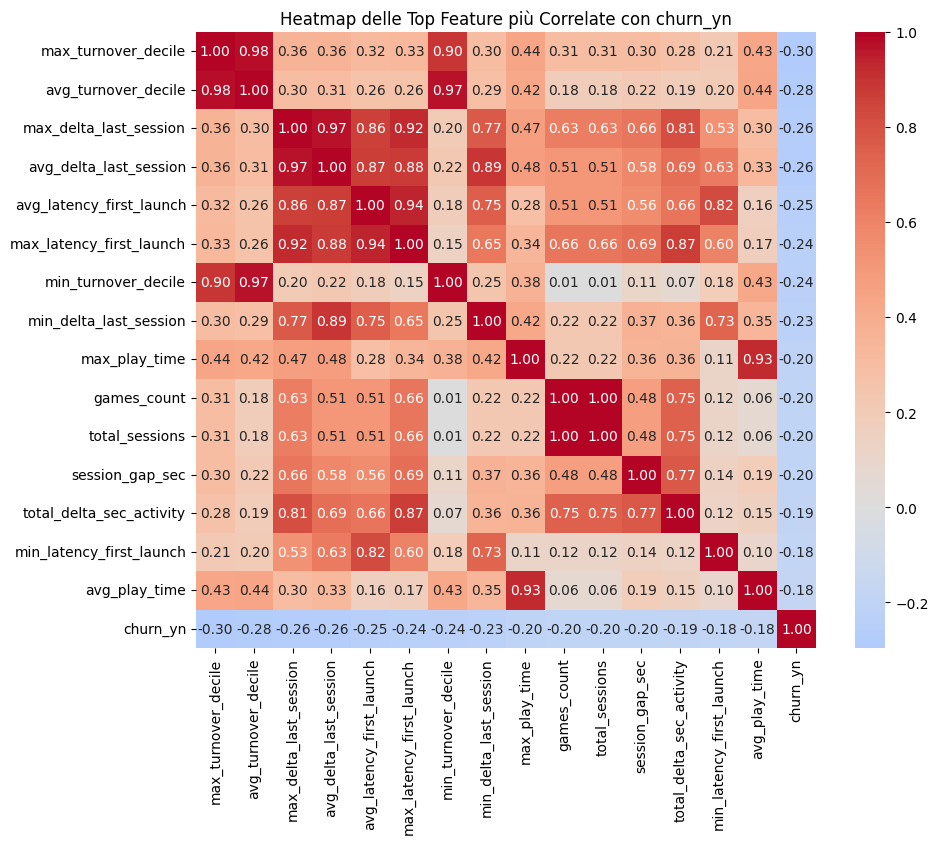

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

df_int = final_training_df.drop('account_id', axis=1).copy()
corr_with_target = df_int.corr(numeric_only=True)["churn_yn"].drop("churn_yn")

corr_with_target = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

top_features = corr_with_target.head(15).index.tolist()

subset_corr = df_int[top_features + ["churn_yn"]].corr(numeric_only=True)

# Heatmap (only first 15 since it is more readable)
plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, cmap="coolwarm", annot=True, fmt=".2f", center=0)
plt.title("Heatmap  Top Feature more Correlated to churn_yn")
plt.show()


# Xgboost model

In [26]:

X =  final_training_df.drop(['account_id', 'churn_yn'],axis=1).copy()
y = final_training_df["churn_yn"]


In [27]:
X.shape


(57860, 30)

In [28]:
y.shape

(57860,)

In [ ]:
X.shape

In [ ]:
y.shape

# Training

Choosing Xgboost to handle tabular data. I won't perform gridsearchCV due to lack of time but it would be best to find the correct XGB parameters.

# Insights
Good churn detection → Precision (0.91) and recall (0.72) show the model is reliable for identifying churners.

Weaker non-churn detection → Many non-churners are incorrectly classified as churn (false positives).

For the business goal (reducing churn), this trade-off may be acceptable: better to over-predict churn than to miss at-risk users.

Next improvements could focus on raising recall for churners even more (catching more at-risk accounts), while trying to reduce unnecessary false positives.

Below shap values conferm what was seen befor about max turnover and similar features, higher values mean less probability of churn, as well as longer session. Finally there is a study on best threshold to predict 1 or 0 based on Precision and recall on target, which shows that 0.4 might be better than 0.5.

Training set shape: (34716, 30)
Validation set shape: (11572, 30)
Test set shape: (11572, 30)
Class distribution in training: churn_yn
0     6652
1    28064
Name: count, dtype: int64
[0]	validation_0-auc:0.72945
[100]	validation_0-auc:0.73818
[200]	validation_0-auc:0.73908
[299]	validation_0-auc:0.73951

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.37      0.69      0.48      2217
           1       0.91      0.72      0.80      9355

    accuracy                           0.71     11572
   macro avg       0.64      0.70      0.64     11572
weighted avg       0.80      0.71      0.74     11572

ROC-AUC Score: 0.7481
Average Precision Score: 0.9107


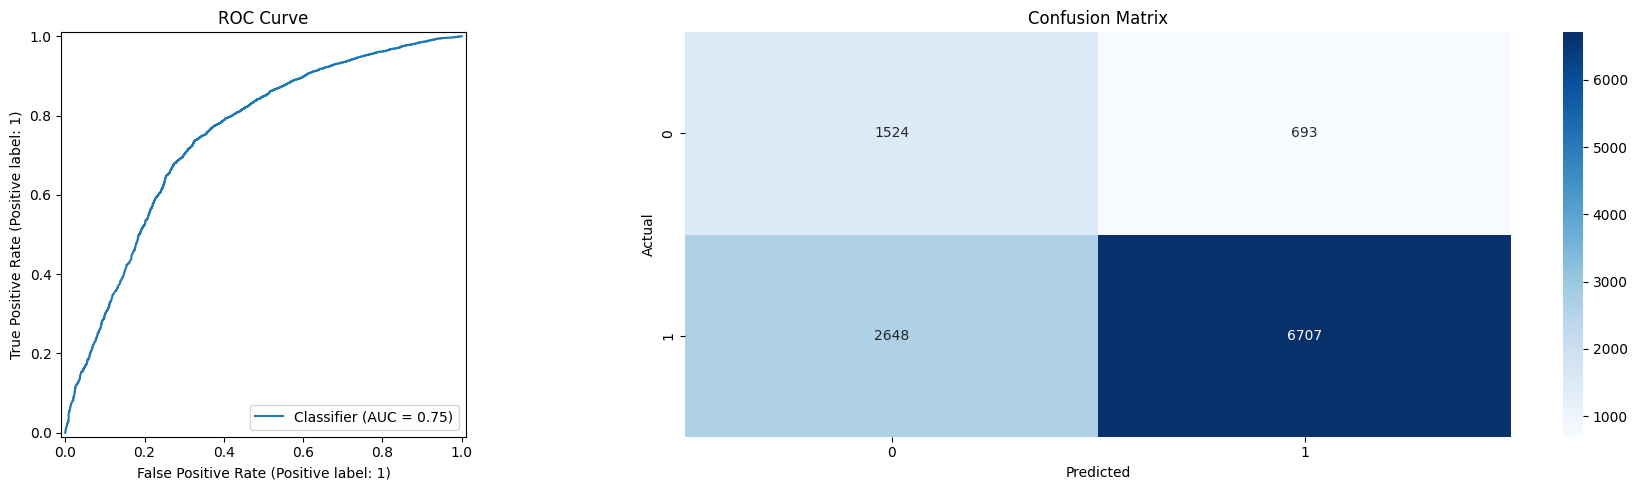

In [49]:

# =====================
# 1. Train / Validation / Test split
# =====================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {y_train.value_counts().sort_index()}")

# =====================
# 2.  class weight imbalance
# =====================
churn_ratio = y_train.sum() / len(y_train)
scale_pos_weight = (1 - churn_ratio) / churn_ratio

# =====================
# 3. XGBoost Model Training
# =====================
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100,
)

# =====================
# Prediction on test set
# =====================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_prob):.4f}")

# =====================
# Performance
# =====================
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[0])
axes[0].set_title('ROC Curve')


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [50]:
# =====================
# 10. Model Performance Summary
# =====================
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Total features used: {X.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Class distribution (churn rate): {y.mean():.1%}")


MODEL PERFORMANCE SUMMARY
Total features used: 30
Training samples: 34716
Validation samples: 11572
Test samples: 11572
Class distribution (churn rate): 80.8%


# Explanation

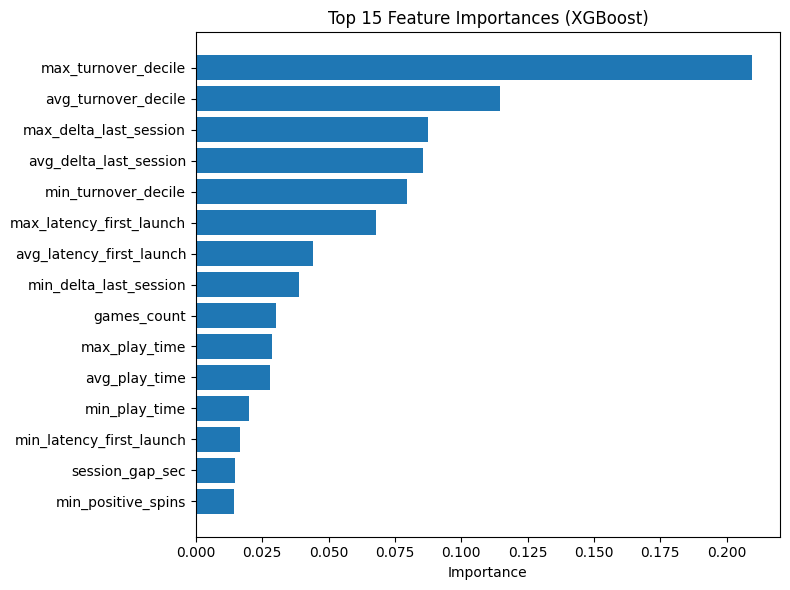


Generating SHAP explanations...


 99%|===================| 11451/11572 [00:56<00:00]       

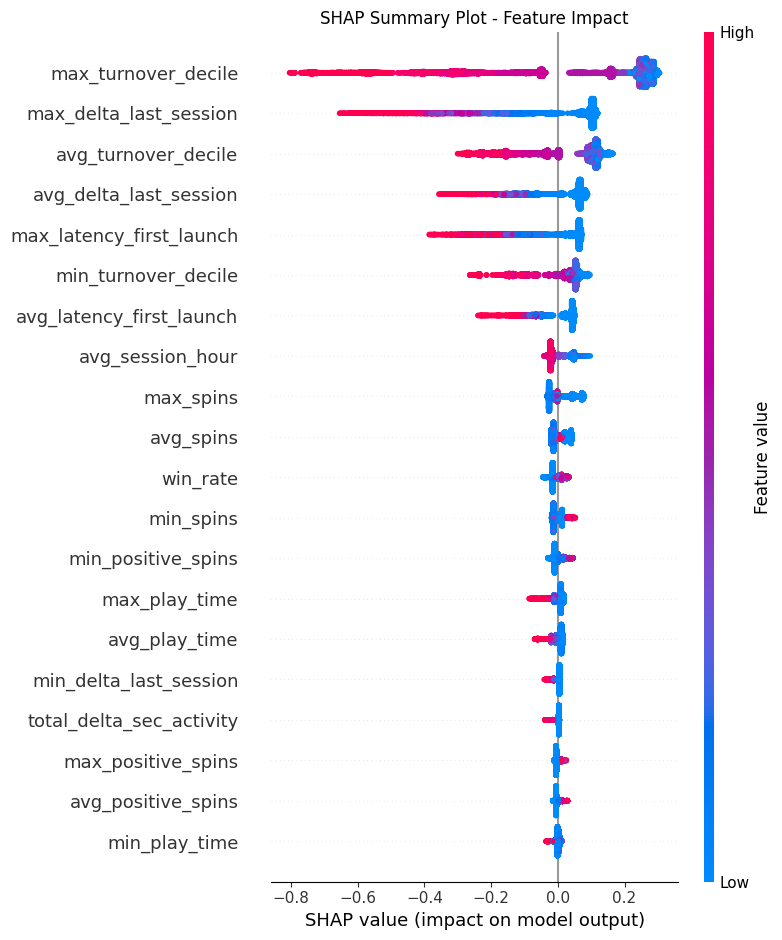

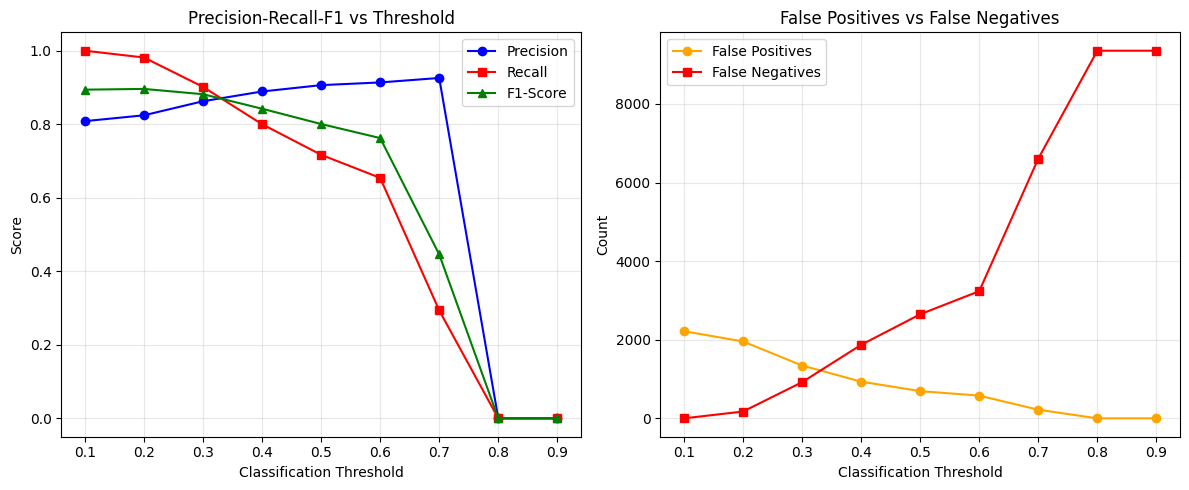

In [52]:

# =====================
# 6. Feature Importance (XGBoost built-in)
# =====================
feat_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

# Top 15 features
top_features = feat_imp_df.tail(15)
plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# =====================
# 7. SHAP Analysis
# =====================
print("\nGenerating SHAP explanations...")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot - Feature Impact')
plt.tight_layout()
plt.show()


# =====================
# 9. Threshold Analysis for Business Decisions
# =====================
thresholds = np.arange(0.1, 1.0, 0.1)
metrics = []

for threshold in thresholds:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    })

metrics_df = pd.DataFrame(metrics)

# Plot threshold analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics_df['threshold'], metrics_df['precision'], 'b-', label='Precision', marker='o')
plt.plot(metrics_df['threshold'], metrics_df['recall'], 'r-', label='Recall', marker='s')
plt.plot(metrics_df['threshold'], metrics_df['f1'], 'g-', label='F1-Score', marker='^')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics_df['threshold'], metrics_df['false_positives'], 'orange', label='False Positives', marker='o')
plt.plot(metrics_df['threshold'], metrics_df['false_negatives'], 'red', label='False Negatives', marker='s')
plt.xlabel('Classification Threshold')
plt.ylabel('Count')
plt.title('False Positives vs False Negatives')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




